# **Relazione finale**

**Gruppo**: BigCovid

**Componenti del gruppo**: Alessio Verdolini, Federico Gaglio

# *Indice*

1. **Analisi del dataset**

2. **Commons**

3. **Primo job**

  3.1 *MapReduce*
  
  3.2 *Hive*

  3.3 *Spark*

  3.4 *Risultati*

  3.5 *Grafici*
  

4. **Secondo job**

  4.1 *MapReduce*

  4.2 *Hive*

  4.3 *Spark*

  4.4 *Risultati*

  4.5 *Grafici*
  
  
5. **Terzo job**

  5.1 *MapReduce*

  5.2 *Hive*

  5.3 *Spark*

  5.4 *Risultati*

  5.5 *Grafici*

# 1. Analisi del dataset

# 2. Commons

### 2.1 Grafici


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import csv

CSV_PATH='time-execute/'


def draw_plot(job_number):
    LOCAL = CSV_PATH+'local_'+str(job_number)+'.csv'
    CLUSTER = CSV_PATH+'cluster_'+str(job_number)+'.csv'
    
    dataset={}
    data_local = {}
    data_cluster = {}
    
    with open(LOCAL,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_local[job]=[float(x) for x in times]
        dataset[0] = {
            'name': "Locale",
            'time': data_local
        }
    
    with open(CLUSTER,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter=',')
        for row in plots:
            job, *times=row
            data_cluster[job]=[float(x) for x in times]
        dataset[1] = {
            'name': "Cluster",
            'time': data_cluster
        }
        
    plot, axs = plt.subplots(1, 2, figsize=(15, 5))

    for i in range(0,2):
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['1'], color='tab:blue', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['2'], color='tab:orange', marker='o')
        axs[i].plot(dataset[i]['time']['dim'], dataset[i]['time']['3'], color='tab:green', marker='o')
        
        axs[i].set_title(dataset[i]['name'])
        axs[i].set_xlabel('Dimensione (MB)')
        axs[i].set_ylabel('Tempo (s)')
        axs[i].grid(alpha=0.4)
        axs[i].legend(['MapReduce', 'Hive', 'Spark'])

### 2.2 MapReduce

#### 2.2.1 Oggetti MapReduce

**AverageObject**

Oggetto utilizzato per facilitare la lettura del codice astraendo la logica del calcolo della media dal resto dell'algoritmo.

L'oggetto offre due meotodi:

1. **add**: aggiorna lo stato della memoria.
2. **avg**: esegue la media effettiva.

In [0]:
class AverageObject:

    def __init__(self, value=0.0):
        self.value = value
        self.count = 1 if value else 0

    def add(self, value):
        self.value += value
        self.count += 1
        
    def avg(self):
        return self.value / self.count


**Record**

Oggetto utilizzato per memorizzare, utilizzando tre differenti istanze del suddetto AverageObject, i seguenti valori:

1. **Volume medio**

2. **Variazione percentuale media**

3. **Variazione media giornaliera**

Utilizzando i tre metodi presenti all'interno dell'oggetto è possibile modificare i rispettivi valori di interesse. 

*Esempio:*

```json
Record = {
    'avg_year_volume': AverageObject,
    'avg_year_change_company': AverageObject,
    'avg_daily_price': AverageObject,
}
```

In [0]:
class Record:

    def __init__(self):
        self.avg_year_volume = AverageObject()
        self.avg_year_change_company = AverageObject()
        self.avg_daily_price = AverageObject()

    def add_volume(self, volume):
        self.avg_year_volume.add(volume)

    def add_year_change(self, year_change):
        self.avg_year_change_company.add(year_change)
        
    def add_daily_price(self, daily_price):
        self.avg_daily_price.add(daily_price)

**Sector**

Oggetto che memorizza il nome del settore e, per ogni anno, i tre parametri richiesti dall'esercizio.

Per la memorizzazione dei parametri utilizziamo un dizionario con chiave **anno** e valore un oggetto **Record**.

*Esempio:*

```json
Sector = {
    'name': 'NomeSettore',
    'year_2_record': {
            '2008': Record,
            '2009': Record,
            '2010': Record
    }
}
```

In [0]:
class Sector:

    def __init__(self, name):
        self.name = name
        self.year_2_record = {}
        
    def update(self, year, volume, year_change, daily_price):
        if not (year in self.year_2_record):
            self.year_2_record[year] = Record()
        self.year_2_record[year].add_volume(volume)
        self.year_2_record[year].add_year_change(year_change)
        self.year_2_record[year].add_daily_price(daily_price)

**Company**

Oggetto utilizzato per memorizzare il nome dell'azienda e le rispettive variazioni di quotazione annuali degli ultimi tre anni.


*Esempio:*

```json
Company = {
    'name': 'NomeAzienda',
    'change_year': {
            '2016': +10%,
            '2017': -1%,
            '2018': +3%
    }
}
```

In [0]:
class Company:
  
    def __init__(self, name):
        self.name = name
        self.change_year = {}

#### 2.2.2 Estrazione da file esterni

Questi snippets vengono utilizzati all'interno dei mapper per l'estrazione delle informazioni riguardanti rispettivamente settore e nome delle aziende, associando mediante un dizionario ai rispettivi ticker. 

Questa operazione permette successivamente di effettuare un merge dei due dataset.


*Esempio:*

```json
ticker_2_Sector = {
    'APP': 'Settore Inc.',
    'MIC': 'Settore Inc.',
    'FAC': 'Settore Inc.',
}
```

```json
ticker_2_Name = {
    'APP': 'Apple Inc.',
    'MIC': 'Microsoft Inc.',
    'FAC': 'Facebook Inc.',
}
```

In [0]:
import csv

STOCKS_INFO_FILE = 'historycal_stocks.csv'

ticker_2_Sector = {}

with open(STOCKS_INFO_FILE) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    firstLine = True

    for row in csv_reader:
        if not firstLine:
            ticker, _, _, sector, _ = row
            if sector != 'N/A':
                ticker_2_Sector[ticker] = sector
        else:
            firstLine = False
            
ticker_2_name = {}

with open(STOCKS_INFO_FILE) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    firstLine = True

    for row in csv_reader:
        if not firstLine:
            ticker, _, name, _, _ = row
            if name != 'N/A':
                ticker_2_name[ticker] = name
        else:
            firstLine = False

### 2.3 Hive

#### 2.3.1 Creazione delle tabelle partendo da file csv

La prima query viene utilizzata per creare la tabella `historical_stock_prices` che contiene tutti i campi del file csv originale effettuando appositi cast in funzione del tipo del campo.

Questa tabella sarà utile per estrarre i dati relativi a:

<br>


|Colonna|Descrizione|
|:-------:|:-----:|
|ticker|Il ticker di riferimento|
|close|La quotazione del ticker a fine giornata|
|volume|Il volume giornaliero sul singolo ticker|
|data|La data di registrazione del record (data)|

<br>

L'espressione `TBLPROPERTIES("skip.header.line.count"="1")` viene utilizzata per escludere dall'elaborazione la prima riga del file contenente l'intestazione.


```sql
CREATE TABLE IF NOT EXISTS historical_stock_prices (
	ticker STRING, 
	open STRING, 
	close double, 
	adj_close STRING, 
	low STRING, 
	high STRING, 
	volume int, 
	data STRING)

ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
TBLPROPERTIES("skip.header.line.count"="1");

LOAD DATA LOCAL INPATH '<path>/<file>.csv' 
OVERWRITE INTO TABLE historical_stock_prices;
```


La seconda query viene utilizzata per creare la tabella `historical_stock` che contiene tutti i campi del file csv originale effettuando appositi cast in funzione del tipo del campo. 

Questa tabella sarà utile per estrarre i dati relativi a:

<br>


|Colonna|Descrizione|
|:-------:|:-----:|
|ticker|Il ticker di riferimento|
|name|Il nome dell'azienda proprietaria del ticker|
|sector|Il settore di competenza dell'azienda|

<br>

```sql
CREATE TABLE IF NOT EXISTS historical_stock (
	ticker STRING, 
	exchanges STRING, 
	name STRING, 
	sector STRING, 
	industry STRING)
ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
TBLPROPERTIES("skip.header.line.count"="1");

LOAD DATA LOCAL INPATH '<path>/<file>.csv' 
OVERWRITE INTO TABLE historical_stock;
```

# 3. Primo job

### 3.1 Map Reduce

Un job che sia in grado di generare le statistiche di ciascuna azione tra il 2008 e il 2018 indicando, per ogni azione: (a) il simbolo, (b) la variazione della quotazione (differenza percentuale arrotondata tra i prezzi di chiusura iniziale e finale dell’intervallo temporale), (c) il prezzo minimo, (e) quello massimo e (f) il volume medio nell’intervallo, ordinando l’elenco in ordine decrescente di variazione della quotazione.

**Config**

Usiamo campi come chiavi: *ticker* come chiave primaria usata per aggregare 
 i dati da passare al reducer e *date* per effettuare l'ordinamento secondario sui valori delle date.

```
-D stream.num.map.output.key.fields=2 
-D mapreduce.job.reduces=1 
```

**Mapper**


In fase di mapping estraiamo da ciascun record i campi *ticker*, *date*, *close*, *volume*.

```python
class Mapper:

  for line in file.csv

    extract ticker, close, volume, date from file.csv
    
    if year in (2008, 2018)
      send to reducer ticker, data, close, volume
```

**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

```python
class Reducer:
  
  define AvgVolume object

  for line in mapper output

    extract ticker, year, close, volume

    percentage_change = ((close_price_final_value - close_price_starting_value) / close_price_starting_value) * 100
    min_price = min(close)
    max_price = max(close)
    avg_volume = avg(volume)
    
    sorting values based on percentage_change key
```



### 3.2 Hive

**Implementazione Hive**

---

```
ticker_min_max_avg(ticker, min_price, max_price, avg_volume) 
```

>**min_price:** *Valore minimo di chiusura*
<br>
>**max_price:** *Valore massimo di chiusura*
<br>
>**avg_volume:** *Volume medio nell'intervallo*

<br>

```
ticker_first_last_data(ticker, first_data, last_data) 
```

>**first_data:** *La prima data in cui è stato quotato il ticker*
<br>
>**last_data:** *L'ultima data in cui è stato quotato il ticker*

<br>

```
ticker_close_first_data(ticker, data, first_price) 
```
>**first_price**: *Valore iniziale di chiusura*

<br>

```
ticker_close_last_data(ticker, data, last_price) 
```
>**last_price**: *Valore finale di chiusura*

<br>

```
ticker_percentage(ticker, inc_per) 
```
>**inc_per**: *Variazione di quotazione (((last_price-first_price)/first_price)x100)*


```sql
CREATE TABLE IF NOT EXISTS ticker_min_max_avg AS
SELECT ticker, min(close) AS min_price, max(close) AS max_price, avg(volume) AS avg_volume
FROM historical_stock_prices
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_first_last_data AS
SELECT ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data
FROM historical_stock_prices
WHERE YEAR(data)>=2008 AND YEAR(data)<=2018
GROUP BY ticker;

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS
SELECT h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data AS t
JOIN historical_stock_prices AS h
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS
SELECT h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data AS t
JOIN historical_stock_prices AS h
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS
SELECT fc.ticker, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker;

CREATE TABLE IF NOT EXISTS result_job_1 AS 
SELECT t.ticker, p.inc_per, t.min_price, t.max_price, t.avg_volume
FROM ticker_min_max_avg AS t
JOIN ticker_percentage AS p
ON t.ticker=p.ticker 
ORDER BY p.inc_per DESC limit 10;
```

### 3.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 3.4 Risultati

Si mostra ora l'output restituito per il primo job:

<br>


|Ticker|Variazione percentuale|Min|Max|Volume medio|
|:-------:|:-----:||:-------:|:-----:|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|

<br>

### 3.5 Grafici

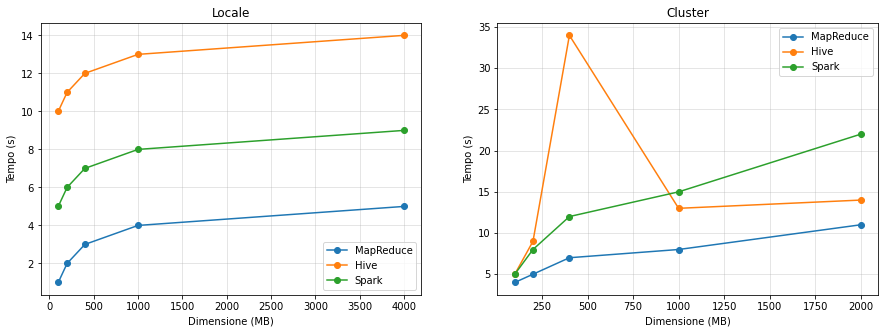

In [0]:
draw_plot(1)

# 4. Secondo job

### 4.1 Map Reduce

Un job che sia in grado di generare, per ciascun settore, il relativo “trend” nel periodo 2008-2018 ovvero un elenco contenete, per ciascun anno nell’intervallo: (a) il volume annuale1 medio delle azioni del settore, (b) la variazione annuale2 media delle aziende del settore e (c) la quotazione giornaliera media delle aziende del settore.

**Config**




In [0]:
-D stream.num.map.output.key.fields=3 
-D mapreduce.partition.keypartitioner.options=-k1,1 
-D mapreduce.job.reduces=1 

SyntaxError: invalid syntax (<ipython-input-4-fc0f63db3433>, line 1)

**Mapper**

In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal file caricato su Hadoop estraiamo i campi *ticker*, *close*, *volume*, *date*, mentre dal file che leggiamo direttamente dal nostro IDE estraiamo i campi *ticker* e *sector*.
Le chiavi che vengono usate in questo secondo job sono 3: *sector*, *ticker* e *date*.


In [0]:
#PSEUDO MAPPER

class Mapper:

  extract ticker, sector from localFile

  for line in input
    extract ticker, close, volume, date

    if year in (2008,2018)
      send to reducer sector, ticker, date, close, volume

**Reducer**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo dei dati di interesse siamo andati a definire 3 oggetti differenti.

In [0]:
#PSEUDO REDUCER

class Reducer:

  #TODO
  

### 4.2 Hive

**Implementazione Hive**

---

```
ticker_data_volume(sector, ticker, anno, sum_volume) 
```

>**sum_volume**: *Volume totale di un ticker in un anno*

<br>

```
sector_data_avg_volume(sector, anno, avg_volume ) 
```

>**avg_volume**: *Volume annuale medio delle azioni del settore*

<br>

```
ticker_first_last_data_year(sector, ticker, first_data, last_data) 
```

>**first_data**: *La prima data in cui è stato quotato il ticker in un anno*
<br>
>**last_data**: *L'ultima data in cui è stato quotato il ticker in un anno*

<br>
 
```
ticker_close_first_data(sector, ticker, data, first_price) 
```

>**first_price**: *Primo valore di chiusura in un anno*

<br>
 
```
ticker_close_last_data(sector, ticker, data, last_price) 
```

>**last_price**: *Ultimo valore di chiusura in un anno*

<br>

```
ticker_percentage(sector, ticker, anno, inc_per) 
```

>**inc_per**: *Variazione della quotazione nell'anno(((last_price-first_price)/first_price)x100)*

<br>

```
sector_avg_percentage(sector, anno, avg_per) 
```

>**avg_per**: *La variazione annuale media delle aziende del settore in un anno*

<br>

```
ticker_avg_price(sector, ticker, anno, avg_ticker_price) 
```

>**avg_ticker_price**: *La quotazione giornaliera media del ticker in un anno*

<br>
 
```
sector_avg_price(sector, anno, avg_sector_price) 
```

>**avg_sector_price**: *La quotazione giornaliera media delle aziende del settore in un anno*


```sql
CREATE TABLE IF NOT EXISTS main_table AS 
SELECT hs.sector, hsp.ticker, hsp.data, hsp.close, hsp.volume 
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2008 AND YEAR(hsp.data)<=2018 
AND hs.sector!='N/A';

CREATE TABLE IF NOT EXISTS ticker_data_volume AS 
SELECT sector, ticker, YEAR(data) AS anno, SUM(volume) AS sum_volume 
FROM main_table 
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS sector_data_avg_volume AS 
SELECT sector, anno, AVG(sum_volume) AS avg_volume 
FROM ticker_data_volume 
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS ticker_first_last_data_year AS 
SELECT sector, ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data 
FROM main_table 
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS 
SELECT t.sector, h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS 
SELECT fc.sector, fc.ticker, YEAR(fc.data) as anno, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per 
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker AND YEAR(lc.data)=YEAR(fc.data);

CREATE TABLE IF NOT EXISTS sector_avg_percentage AS 
SELECT sector, anno, AVG(inc_per) AS avg_per
FROM ticker_percentage
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS ticker_avg_price AS
SELECT sector, ticker, YEAR(data) AS anno, AVG(close) AS avg_ticker_price
FROM main_table
GROUP BY sector, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS sector_avg_price AS
SELECT sector, anno, AVG(avg_ticker_price) AS avg_sector_price
FROM ticker_avg_price
GROUP BY sector, anno;

CREATE TABLE IF NOT EXISTS result_job_2 AS 
SELECT a.sector, a.anno, a.avg_volume, b.avg_per, c.avg_sector_price 
FROM sector_data_avg_volume AS a
JOIN sector_avg_percentage AS b
JOIN sector_avg_price AS c 
ON a.sector=b.sector AND b.sector=c.sector AND a.anno=b.anno AND b.anno=c.anno
ORDER BY sector, anno;

```

### 4.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 4.4 Risultati

Si mostra ora l'output restituito per il primo job:

<br>


|Ticker|Variazione percentuale|Min|Max|Volume medio|
|:-------:|:-----:||:-------:|:-----:|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|

<br>

### 4.5 Grafici

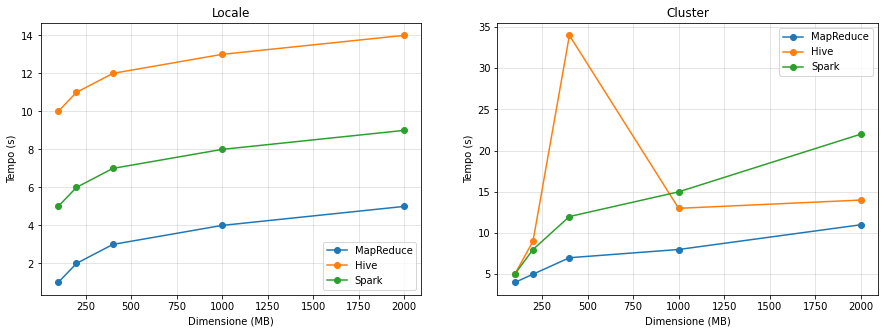

In [0]:
draw_plot(2)

# 5. Terzo job

### 5.1 Map Reduce

Un job in grado di generare gruppi di aziende le cui azioni hanno avuto lo stesso trend in termini di variazione annuale nell’ultimo triennio disponibile, indicando le aziende e il trend comune (es. {Apple, Intel, Amazon}: 2016:-1%, 2017:+3%, 2018:+5%).

**Config**




In [0]:
#Prima passata
    
-D stream.num.map.output.key.fields=2
-D mapreduce.partition.keypartitioner.options=-k1,1
-D mapreduce.job.reduces=1
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner


In [0]:
#Seconda passata

-D stream.num.map.output.key.fields=3
-D mapreduce.job.reduces=1

**Mapper 1**


In fase di mapping andiamo a estrarre da due file differenti i record di interesse. In particolare dal primo estraiamo i campi *ticker*, *close*, *date*, mentre dal secondo estraiamo i campi *ticker* e *name*.
Le chiavi che vengono usate in questo secondo job sono 2: *sector*, *date*.

In [0]:
#PSEUDO MAPPER1

class Mapper:

  extract ticker, name from localFile

  for line in input
    extract ticker, close, date

    if year in (2016,2018)
      send to reducer1 ticker, date, close, name


**Reducer 1**

In fase di reducing, dopo aver estratto i valori passati dal mapper, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

In [0]:
#PSEUDO REDUCER 1

#TODO


**Mapper 2**

Questo secondo mapper l'unica cosa che va a fare è leggere l'output del primo reducer da Hadoop e lo va a passare al secondo reducer

In [0]:
for line in input
  send line to reducer2 

**Reducer 2**

In fase di reducing, dopo aver estratto i valori passati dal mapper2, andiamo a calcolare i punti definiti nell'hw; in particolare per il calcolo del volume abbiamo creato un oggetto(avgVolume) per semplificarci il calcolo.

In [0]:
#PESUDO REDUCER2

#todo


### 5.2 Hive

**Implementazione Hive**

---

```
ticker_first_last_data_year(sector, ticker, first_data, last_data) 
```

>**first_data**: *La prima data in cui è stato quotato il ticker in un anno*
<br>
>**last_data**: *L'ultima data in cui è stato quotato il ticker in un anno*

<br>
 
```
ticker_close_first_data(sector, ticker, data, first_price) 
```

>**first_price**: *Primo valore di chiusura in un anno*

<br>
 
```
ticker_close_last_data(sector, ticker, data, last_price) 
```

>**last_price**: *Ultimo valore di chiusura in un anno*

<br>

```
ticker_percentage(sector, ticker, anno, inc_per) 
```

>**inc_per**: *Variazione della quotazione nell'anno(((last_price-first_price)/first_price)x100)*

<br>

---

```
first_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel primo anno*

<br>

---

```
second_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel secondo anno*

<br>

---

```
third_year(name, inc_per) 
```

>**inc_per**: *Variazione della quotazione nel terzo anno*

<br>

---

```
result_job_3(name, primo, secondo, terzo) 
```

>**primo**: *Variazione della quotazione nel primo anno*
<br>
>**secondo**: *Variazione della quotazione nel secondo anno*
<br>
>**terzo**: *Variazione della quotazione nel terzo anno*

<br>

---

```
SELECT collect_set(name), primo, secondo, terzo
FROM result_job_3 
GROUP BY primo, secondo, terzo;
```

> *La query genera liste di aziende aventi lo stesso trend nei tre anni*

<br>

```sql
CREATE TABLE IF NOT EXISTS main_table AS 
SELECT hs.name, hsp.ticker, hsp.data, hsp.close
FROM historical_stock AS hs 
JOIN historical_stock_prices AS hsp 
ON hsp.ticker=hs.ticker 
WHERE YEAR(hsp.data)>=2016 AND YEAR(hsp.data)<=2018 
AND hs.name!='N/A';

CREATE TABLE IF NOT EXISTS ticker_first_last_data_year AS 
SELECT name, ticker, min(TO_DATE(data)) AS first_data, max(TO_DATE(data)) AS last_data 
FROM main_table 
GROUP BY name, ticker, YEAR(data);

CREATE TABLE IF NOT EXISTS ticker_close_first_data AS 
SELECT t.name, h.ticker, h.data, h.close AS first_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.first_data;

CREATE TABLE IF NOT EXISTS ticker_close_last_data AS 
SELECT t.name, h.ticker, h.data, h.close AS last_price
FROM ticker_first_last_data_year AS t
JOIN historical_stock_prices AS h 
ON h.ticker=t.ticker AND h.data=t.last_data;

CREATE TABLE IF NOT EXISTS ticker_percentage AS 
SELECT fc.name, fc.ticker, YEAR(fc.data) as anno, (((lc.last_price-fc.first_price)/fc.first_price) * 100) AS inc_per 
FROM ticker_close_last_data AS lc
JOIN ticker_close_first_data AS fc
ON lc.ticker=fc.ticker AND YEAR(lc.data)=YEAR(fc.data);

CREATE TABLE IF NOT EXISTS first_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2016
ORDER BY name;

CREATE TABLE IF NOT EXISTS second_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2017
ORDER BY name;

CREATE TABLE IF NOT EXISTS third_year AS 
SELECT name, inc_per
FROM ticker_percentage
WHERE anno == 2018
ORDER BY name;

CREATE TABLE IF NOT EXISTS result_job_3 AS
SELECT first_year.name, first_year.inc_per AS primo, second_year.inc_per AS secondo, third_year.inc_per AS terzo
FROM first_year, second_year, third_year
WHERE first_year.name = second_year.name AND second_year.name = third_year.name
ORDER BY primo, secondo, terzo;

SELECT collect_set(name), primo, secondo, terzo
FROM result_job_3 
GROUP BY primo, secondo, terzo;

```

### 5.3 Spark

**Implementazione Spark**

In fase di mapping estrapoliamo innanzitutto da ciascun record i campi ticker, close, low, high, volume e date.
Successivamente verifichiamo che il record sia relativo ad un anno che ricada nell'intervallo 1998-2018, per poi stampare la chiave i valori associati alla chiave. In particolare la chiave è composta da due campi: ticker, usata come chiave "primaria", e date usata come chiave "secondaria".
In questo modo valori che verranno ricevuti dal reducer saranno aggregati per il solo campo ticker e ordinati in base al campo date (si parla in questo caso di secondary sort). Questo consentirà nella fase di reduce di evitare comparazioni tra date (per trovare la data più recente e quella meno recente) ai fini del calcolo della differenza percentuale.
Il valore associato alla chiave è invece composto dai campi close, low, high e volume.

In [0]:
#!/usr/bin/env python
import sys

# constant for fields position
TICKER = 0
DATE = 1
CLOSE = 2
VOLUME = 3
  

### 5.4 Risultati

Si mostra ora l'output restituito per il primo job:

<br>


|Ticker|Variazione percentuale|Min|Max|Volume medio|
|:-------:|:-----:||:-------:|:-----:|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|
|MNST|163340.387616%|0.0305979158729|70.2200012207|7347898.8208|

<br>

### 5.5 Grafici

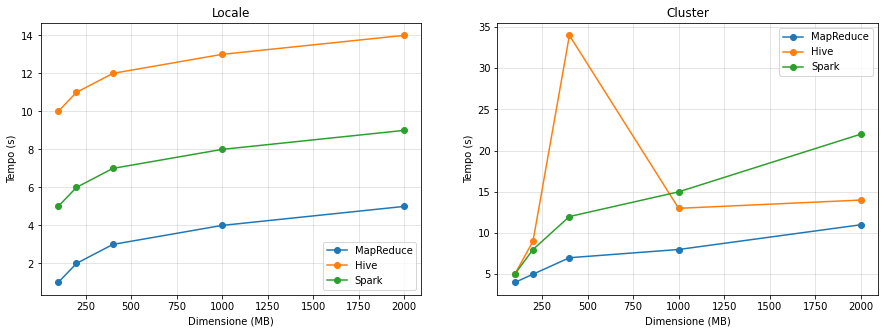

In [0]:
draw_plot(3)